
# PROJET DL : TRANSFER LEARNING




In [13]:
# ============================================================================
# PART 1 : IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.datasets import load_files
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16, MobileNetV2, Xception
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# PART 2 : DOWNLOADING AND LOADING KAGGLE DATASET
# ============================================================================

print("=" * 80)
print("STEP 1 : DOWNLOADING AND LOADING KAGGLE DATASET")
print("=" * 80)

# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print(f"Dataset downloaded: {dataset_path}")

# Build the path to the image folder
dataset_dir = os.path.join(dataset_path, 'flower_images')

print(f"Images folder: {dataset_dir}")

# Load the data
data = load_files(dataset_dir, load_content=False)
class_names = data.target_names
num_classes = len(class_names)
image_paths = np.array(data.filenames)
labels = np.array(data.target)

print("Dataset loaded")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Total number of images: {len(image_paths)}")

STEP 1 : DOWNLOADING AND LOADING KAGGLE DATASET
Dataset downloaded: C:\Users\user\.cache\kagglehub\datasets\kausthubkannan\5-flower-types-classification-dataset\versions\1
Images folder: C:\Users\user\.cache\kagglehub\datasets\kausthubkannan\5-flower-types-classification-dataset\versions\1\flower_images
Dataset loaded
Number of classes: 5
Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
Total number of images: 5000


 Class  Number of images
     0              1000
     3              1000
     4              1000
     2              1000
     1              1000


<Figure size 1000x500 with 0 Axes>

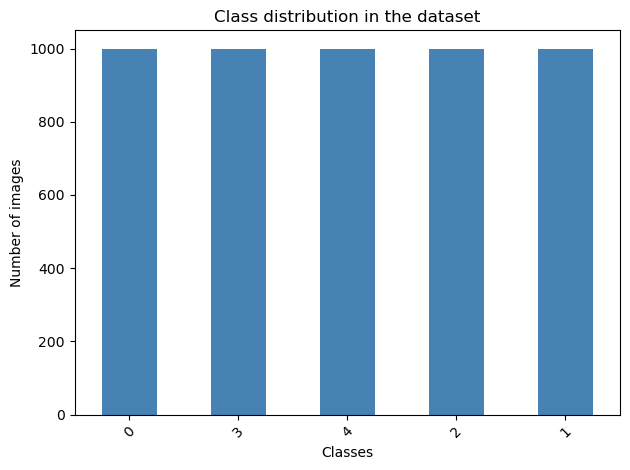

In [3]:
# Convert labels to a pandas Series
serie = pd.Series(labels, name="class")

# Count occurrences of each class
counts = serie.value_counts()

# Create a DataFrame for class distribution
class_distribution = counts.reset_index()
class_distribution.columns = ["Class", "Number of images"]

print(class_distribution.to_string(index=False))

# Plot class distribution
plt.figure(figsize=(10, 5))
class_distribution.plot.bar(x="Class", y="Number of images", color='steelblue', legend=False)
plt.title('Class distribution in the dataset')
plt.xlabel('Classes')
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

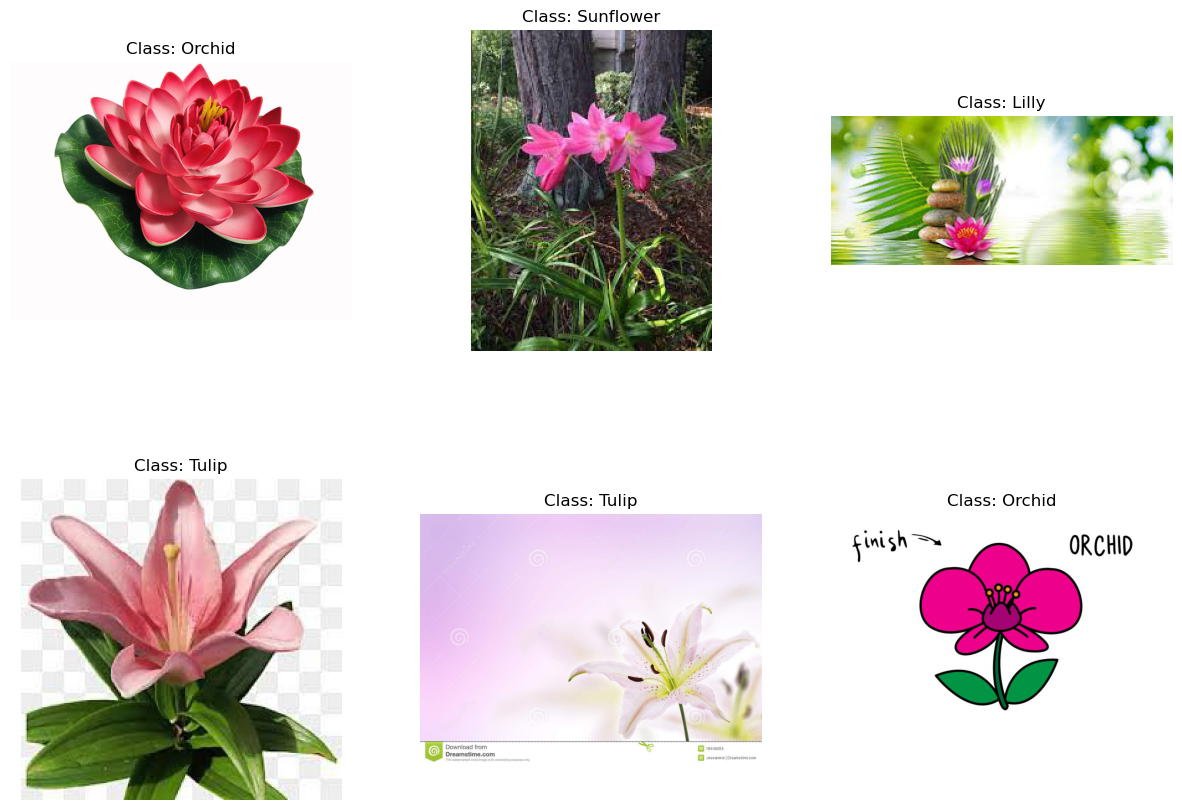

In [4]:
# ============================================================================
# PART 4 : VISUALIZATION OF SAMPLE IMAGES
# ============================================================================

# Convert existing lists into a TensorFlow Dataset
paths = tf.constant(image_paths)
labels_tf = tf.constant(labels)

dataset = tf.data.Dataset.from_tensor_slices((paths, labels_tf))

# Select 6 random images
sample = dataset.shuffle(10000).take(6)

# Extract paths and labels (no explicit for-loop)
chosen_paths = list(sample.map(lambda x, y: x).as_numpy_iterator())
chosen_labels = list(sample.map(lambda x, y: y).as_numpy_iterator())

# Load the images (still without explicit loops)
loaded_imgs = list(map(lambda p: tf.keras.utils.load_img(p), chosen_paths))

# Display the images
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

# Implicit loop using map() + enumerate
list(map(
    lambda info: (
        plt.subplot(2, 3, info[0] + 1),
        plt.imshow(info[1]),
        plt.title(f"Class: {class_names[chosen_labels[info[0]]]}"),
        plt.axis("off")
    ),
    enumerate(loaded_imgs)
))

plt.show()

In [5]:
# ============================================================================
# PART 5 : TRAIN / VALIDATION / TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4 : TRAIN / VALIDATION / TEST SPLIT")
print("=" * 80)

# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"Validation: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"Test: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")


STEP 4 : TRAIN / VALIDATION / TEST SPLIT
Train: 3000 images (60.0%)
Validation: 1000 images (20.0%)
Test: 1000 images (20.0%)


In [6]:
# ============================================================================
# PART 6 : DATA AUGMENTATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5 : DATA AUGMENTATION")
print("=" * 80)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

print("Data augmentation configured successfully")
print("  - Rotation: 40°")
print("  - Width/Height shift: 20%")
print("  - Zoom range: 20%")
print("  - Horizontal flip: Yes")
print("  - Brightness: 80–120%")


STEP 5 : DATA AUGMENTATION
Found 5000 images belonging to 5 classes.
Data augmentation configured successfully
  - Rotation: 40°
  - Width/Height shift: 20%
  - Zoom range: 20%
  - Horizontal flip: Yes
  - Brightness: 80–120%


In [7]:
# ============================================================================
# PART 7 : HYPERPARAMETERS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6 : DEFINING HYPERPARAMETERS")
print("=" * 80)

input_size = (299, 299)
batch_size = 32
epochs = 30
learning_rate_1 = 0.001
learning_rate_2 = 0.0005

print(f"Image size: {input_size}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning rates: {learning_rate_1}, {learning_rate_2}")


STEP 6 : DEFINING HYPERPARAMETERS
Image size: (299, 299)
Batch size: 32
Epochs: 30
Learning rates: 0.001, 0.0005


In [ ]:
# ============================================================================
# MODEL 1 : InceptionV3 with Learning Rate 0.001
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 1 : InceptionV3 (LR = 0.001)")
print("=" * 80)

base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_inception.trainable = False

inputs_1 = Input(shape=(299, 299, 3))
x = base_inception(inputs_1, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs_1 = Dense(num_classes, activation='softmax')(x)

model_1 = Model(inputs_1, outputs_1, name='InceptionV3_001')

model_1.compile(
    optimizer=Adam(learning_rate=learning_rate_1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nInceptionV3 Architecture:")
model_1.summary()

total_params_1 = model_1.count_params()
trainable_params_1 = sum([tf.keras.backend.count_params(w) for w in model_1.trainable_weights])
non_trainable_params_1 = total_params_1 - trainable_params_1

print(f"\n Total parameters: {total_params_1:,}")
print(f" Trainable parameters: {trainable_params_1:,}")
print(f" Frozen parameters: {non_trainable_params_1:,}")

# Training Model 1
early_stop_1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_1 = model_1.fit(
    train_generator,
    epochs=epochs,
    validation_data=train_generator,
    callbacks=[early_stop_1, reduce_lr_1],
    verbose=1
)

test_loss_1, test_acc_1 = model_1.evaluate(train_generator, verbose=0)
print(f"\n Test Loss: {test_loss_1:.4f}")
print(f" Test Accuracy: {test_acc_1:.4f}")

model_1.save('/content/inceptionv3_001.h5')


MODEL 1 : InceptionV3 (LR = 0.001)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

InceptionV3 Architecture:


Model: "InceptionV3_001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,360,869 (85.30 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


 Total parameters: 22,360,869
 Trainable parameters: 558,085
 Frozen parameters: 21,802,784
Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.5236 - loss: 1.1720 - val_accuracy: 0.7996 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.7076 - loss: 0.7918 - val_accuracy: 0.7630 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7482 - loss: 0.6846 - val_accuracy: 0.8150 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7616 - loss: 0.6699 - val_accuracy: 0.8490 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.7736 - loss: 0.6127 - val_accuracy: 0.8458 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7928 - loss: 0.5894 - val_accuracy: 0.8576 - val_loss: 0.4021 - learning_ra


 Test Loss: 0.2507
 Test Accuracy: 0.9112



EVALUATING: InceptionV3 Model


✓ InceptionV3 model loaded

InceptionV3 Results:
  Accuracy: 0.9090
  Loss: 0.2485
  Precision: 0.9121
  Recall: 0.9090
  F1-Score: 0.9087


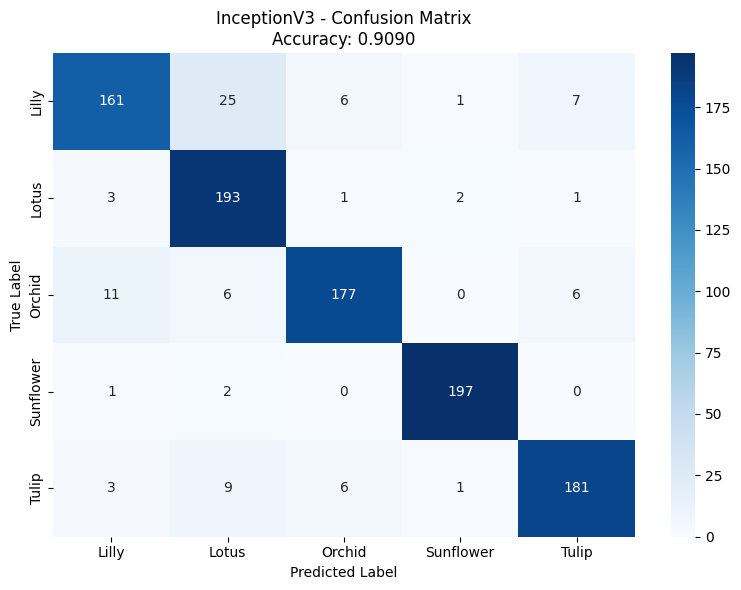

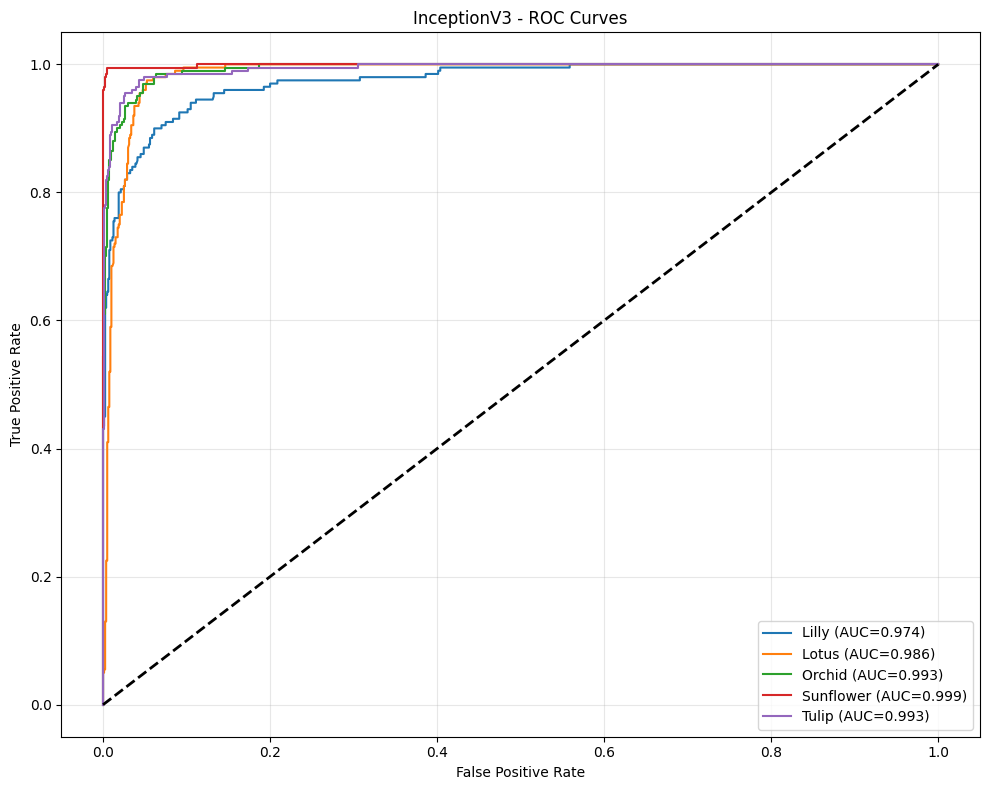

In [ ]:
# ================================================
# InceptionV3 EVALUATION
# ================================================
print("\n" + "="*80)
print("EVALUATING: InceptionV3 Model")
print("="*80)

# Load model
model_inception = load_model('/content/inceptionv3_001.h5')
print("✓ InceptionV3 model loaded")

# Load test images (299x299)
X_test_inception = np.array([img_to_array(load_img(p, target_size=(299,299)))/255.0 for p in X_test])
y_test_categorical = pd.get_dummies(y_test).values

# Evaluate
test_loss_inception, test_acc_inception = model_inception.evaluate(X_test_inception, y_test_categorical, verbose=0)

# Predictions
y_pred_proba_inception = model_inception.predict(X_test_inception, verbose=0)
y_pred_inception = np.argmax(y_pred_proba_inception, axis=1)
y_true_inception = np.argmax(y_test_categorical, axis=1)

# Metrics
f1_inception = f1_score(y_true_inception, y_pred_inception, average='weighted')
precision_inception = precision_score(y_true_inception, y_pred_inception, average='weighted')
recall_inception = recall_score(y_true_inception, y_pred_inception, average='weighted')

print("\nInceptionV3 Results:")
print(f"  Accuracy: {test_acc_inception:.4f}")
print(f"  Loss: {test_loss_inception:.4f}")
print(f"  Precision: {precision_inception:.4f}")
print(f"  Recall: {recall_inception:.4f}")
print(f"  F1-Score: {f1_inception:.4f}")

# Confusion Matrix
cm_inception = confusion_matrix(y_true_inception, y_pred_inception)
plt.figure(figsize=(8,6))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'InceptionV3 - Confusion Matrix\nAccuracy: {test_acc_inception:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curves
y_true_bin_inception = label_binarize(y_true_inception, classes=range(len(class_names)))

fpr0, tpr0, _ = roc_curve(y_true_bin_inception[:,0], y_pred_proba_inception[:,0])
auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_true_bin_inception[:,1], y_pred_proba_inception[:,1])
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_true_bin_inception[:,2], y_pred_proba_inception[:,2])
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_true_bin_inception[:,3], y_pred_proba_inception[:,3])
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_true_bin_inception[:,4], y_pred_proba_inception[:,4])
auc4 = auc(fpr4, tpr4)

plt.figure(figsize=(10,8))
plt.plot(fpr0, tpr0, label=f'{class_names[0]} (AUC={auc0:.3f})')
plt.plot(fpr1, tpr1, label=f'{class_names[1]} (AUC={auc1:.3f})')
plt.plot(fpr2, tpr2, label=f'{class_names[2]} (AUC={auc2:.3f})')
plt.plot(fpr3, tpr3, label=f'{class_names[3]} (AUC={auc3:.3f})')
plt.plot(fpr4, tpr4, label=f'{class_names[4]} (AUC={auc4:.3f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionV3 - ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# ============================================================================
# MODEL 2 : ResNet50 with fine-tuning, based on existing train/val/test split
# ============================================================================

print("\n" + "="*80)
print("MODEL 2 : ResNet50 (Fine-tuning, LR = 0.0005)")
print("="*80)

# =======================
# Convert labels to categorical
# =======================
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# =======================
# Base ResNet50
# =======================
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_resnet.trainable = False  # freeze base

# Custom top
inputs = Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs, outputs, name='ResNet50_finetune')

model_resnet.compile(
    optimizer=Adam(learning_rate=learning_rate_2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResNet50 Architecture:")
model_resnet.summary()

# =======================
# Data generators using arrays
# =======================
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    np.array([img_to_array(load_img(p, target_size=(224,224))) for p in X_train]),
    y_train_cat,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    np.array([img_to_array(load_img(p, target_size=(224,224))) for p in X_val]),
    y_val_cat,
    batch_size=batch_size,
    shuffle=False
)

# =======================
# Fine-tuning: unfreeze last 30 layers
# =======================
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =======================
# Callbacks
# =======================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# =======================
# Training
# =======================
history = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# =======================
# Evaluation on validation set
# =======================
val_loss, val_acc = model_resnet.evaluate(val_generator, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# =======================
# Save model (modern Keras format)
# =======================
model_resnet.save("resnet50_finetuned.keras")
print("\nModel saved as resnet50_finetuned.keras")



MODEL 2 : ResNet50 (Fine-tuning, LR = 0.0005)

ResNet50 Architecture:


Model: "ResNet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5800 - loss: 1.0535 - val_accuracy: 0.8520 - val_loss: 0.5702 - learning_rate: 1.0000e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8247 - loss: 0.4813 - val_accuracy: 0.8890 - val_loss: 0.4226 - learning_rate: 1.0000e-04
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8757 - loss: 0.3526 - val_accuracy: 0.8940 - val_loss: 0.4031 - learning_rate: 1.0000e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9130 - loss: 0.2774 - val_accuracy: 0.9040 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9303 - loss: 0.2139 - val_accuracy: 0.9230 - val_loss: 0.2766 - learning_rate: 1.0000e-04
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9540 - loss: 0.1553 - val_accuracy: 0.9210 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9473 


EVALUATING: ResNet50 Model

ResNet50 Results:
  Accuracy: 0.9400
  Loss: 0.2970
  Precision: 0.9405
  Recall: 0.9400
  F1-Score: 0.9398


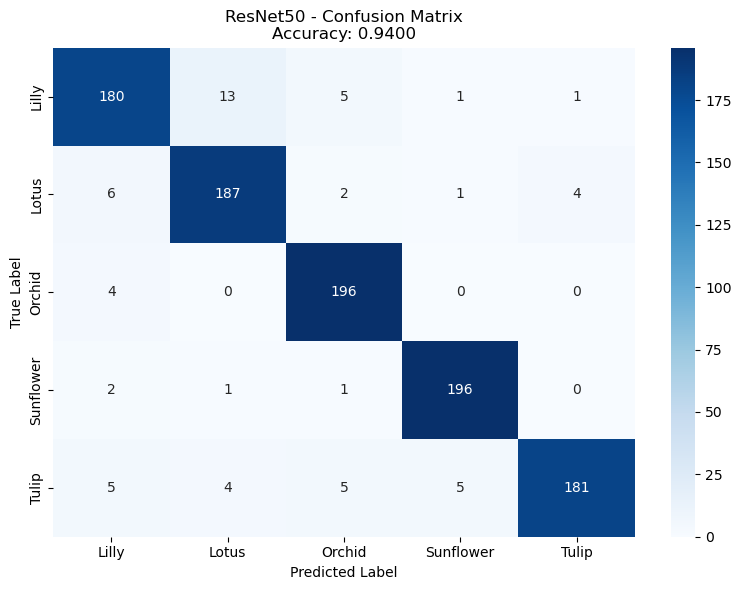

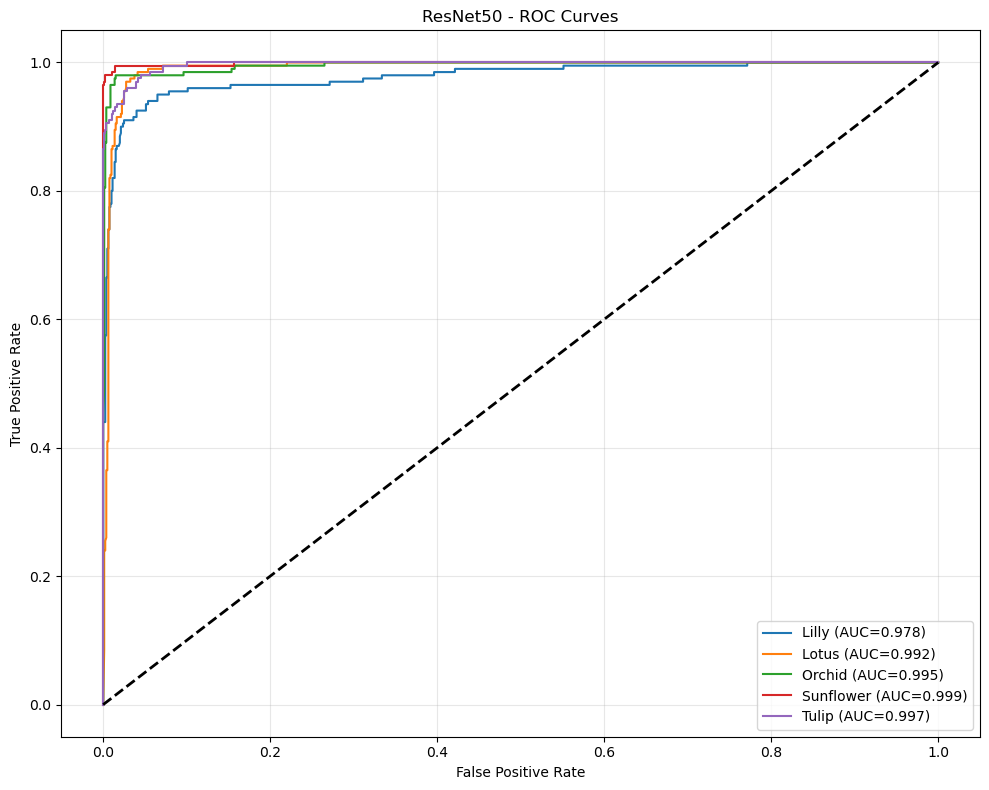

In [14]:
# ================================================
# RESNET50 EVALUATION
# ================================================

print("\n" + "="*80)
print("EVALUATING: ResNet50 Model")
print("="*80)

# =======================
# Preprocess test images (224x224)
# =======================
X_test_resnet = np.array([
    preprocess_input(img_to_array(load_img(p, target_size=(224,224))))
    for p in X_test
])

# One-hot encoding for metrics
y_test_categorical = pd.get_dummies(y_test).values
y_true_resnet = y_test  # integer labels

# =======================
# Evaluate model
# =======================
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test_resnet, y_test_categorical, verbose=0)

# Predictions
y_pred_proba_resnet = model_resnet.predict(X_test_resnet, verbose=0)
y_pred_resnet = np.argmax(y_pred_proba_resnet, axis=1)

# Metrics
f1_resnet = f1_score(y_true_resnet, y_pred_resnet, average='weighted')
precision_resnet = precision_score(y_true_resnet, y_pred_resnet, average='weighted')
recall_resnet = recall_score(y_true_resnet, y_pred_resnet, average='weighted')

print("\nResNet50 Results:")
print(f"  Accuracy: {test_acc_resnet:.4f}")
print(f"  Loss: {test_loss_resnet:.4f}")
print(f"  Precision: {precision_resnet:.4f}")
print(f"  Recall: {recall_resnet:.4f}")
print(f"  F1-Score: {f1_resnet:.4f}")

# =======================
# Confusion Matrix
# =======================
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'ResNet50 - Confusion Matrix\nAccuracy: {test_acc_resnet:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# =======================
# ROC Curves
# =======================
y_true_bin_resnet = label_binarize(y_true_resnet, classes=range(len(class_names)))

plt.figure(figsize=(10,8))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin_resnet[:,i], y_pred_proba_resnet[:,i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC={auc_score:.3f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 - ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# MODEL 3 : VGG16 with Learning Rate 0.001
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3 : VGG16 (LR = 0.001)")
print("=" * 80)

base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg.trainable = False

inputs_3 = Input(shape=(224, 224, 3))
x = base_vgg(inputs_3, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs_3 = Dense(num_classes, activation='softmax')(x)

model_3 = Model(inputs_3, outputs_3, name='VGG16_001')

model_3.compile(
    optimizer=Adam(learning_rate=learning_rate_1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nVGG16 Architecture:")
model_3.summary()

total_params_3 = model_3.count_params()
trainable_params_3 = sum([tf.keras.backend.count_params(w) for w in model_3.trainable_weights])
non_trainable_params_3 = total_params_3 - trainable_params_3

print(f"\n Total parameters: {total_params_3:,}")
print(f" Trainable parameters: {trainable_params_3:,}")
print(f" Frozen parameters: {non_trainable_params_3:,}")

# Training Model 3
early_stop_3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_3 = model_3.fit(
    train_generator_224,
    epochs=epochs,
    validation_data=train_generator_224,
    callbacks=[early_stop_3, reduce_lr_3],
    verbose=1
)

test_loss_3, test_acc_3 = model_3.evaluate(train_generator_224, verbose=0)
print(f"\n Test Loss: {test_loss_3:.4f}")
print(f" Test Accuracy: {test_acc_3:.4f}")

model_3.save('/content/vgg16_001.h5')


MODEL 3 : VGG16 (LR = 0.001)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

VGG16 Architecture:


Model: "VGG16_001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


 Total parameters: 14,879,557
 Trainable parameters: 164,869
 Frozen parameters: 14,714,688
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.3602 - loss: 1.4885 - val_accuracy: 0.6150 - val_loss: 1.1616 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5717 - loss: 1.1096 - val_accuracy: 0.6910 - val_loss: 0.8686 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6435 - loss: 0.9532 - val_accuracy: 0.7180 - val_loss: 0.7857 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.6865 - loss: 0.8410 - val_accuracy: 0.7287 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7035 - loss: 0.7885 - val_accuracy: 0.7667 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7170 - loss: 0.7493 - val_accuracy: 0.7757 - val_loss: 0.6104 - learning_ra


 Test Loss: 0.3847
 Test Accuracy: 0.8633



EVALUATING: VGG16 Model


✓ VGG16 model loaded

VGG16 Results:
  Accuracy: 0.8810
  Loss: 0.3288
  Precision: 0.8840
  Recall: 0.8810
  F1-Score: 0.8799


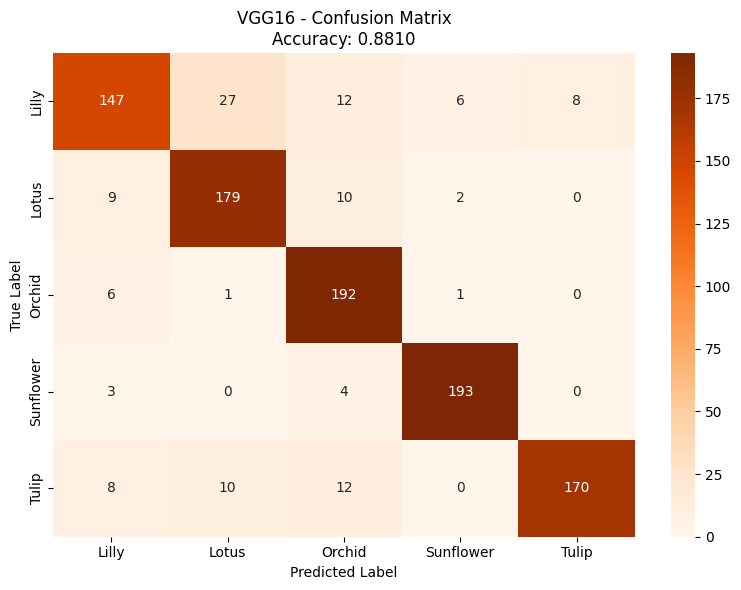

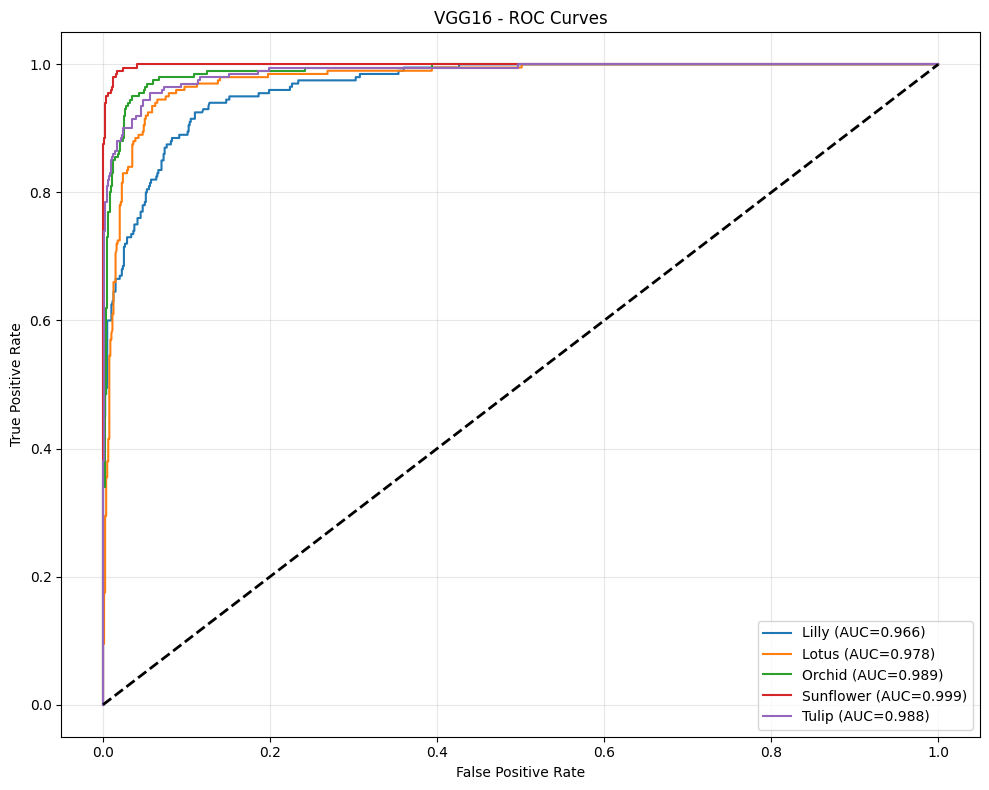

In [ ]:
# ================================================
# VGG16 EVALUATION
# ================================================
print("\n" + "="*80)
print("EVALUATING: VGG16 Model")
print("="*80)

# Load model
model_vgg = load_model('/content/vgg16_001.h5')
print("✓ VGG16 model loaded")

# Load test images (224x224)
X_test_vgg = np.array([img_to_array(load_img(p, target_size=(224,224)))/255.0 for p in X_test])
y_test_categorical = pd.get_dummies(y_test).values

# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(X_test_vgg, y_test_categorical, verbose=0)

# Predictions
y_pred_proba_vgg = model_vgg.predict(X_test_vgg, verbose=0)
y_pred_vgg = np.argmax(y_pred_proba_vgg, axis=1)
y_true_vgg = np.argmax(y_test_categorical, axis=1)

# Metrics
f1_vgg = f1_score(y_true_vgg, y_pred_vgg, average='weighted')
precision_vgg = precision_score(y_true_vgg, y_pred_vgg, average='weighted')
recall_vgg = recall_score(y_true_vgg, y_pred_vgg, average='weighted')

print("\nVGG16 Results:")
print(f"  Accuracy: {test_acc_vgg:.4f}")
print(f"  Loss: {test_loss_vgg:.4f}")
print(f"  Precision: {precision_vgg:.4f}")
print(f"  Recall: {recall_vgg:.4f}")
print(f"  F1-Score: {f1_vgg:.4f}")

# Confusion Matrix
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plt.figure(figsize=(8,6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title(f'VGG16 - Confusion Matrix\nAccuracy: {test_acc_vgg:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curves
y_true_bin_vgg = label_binarize(y_true_vgg, classes=range(len(class_names)))

fpr0, tpr0, _ = roc_curve(y_true_bin_vgg[:,0], y_pred_proba_vgg[:,0])
auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_true_bin_vgg[:,1], y_pred_proba_vgg[:,1])
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_true_bin_vgg[:,2], y_pred_proba_vgg[:,2])
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_true_bin_vgg[:,3], y_pred_proba_vgg[:,3])
auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_true_bin_vgg[:,4], y_pred_proba_vgg[:,4])
auc4 = auc(fpr4, tpr4)

plt.figure(figsize=(10,8))
plt.plot(fpr0, tpr0, label=f'{class_names[0]} (AUC={auc0:.3f})')
plt.plot(fpr1, tpr1, label=f'{class_names[1]} (AUC={auc1:.3f})')
plt.plot(fpr2, tpr2, label=f'{class_names[2]} (AUC={auc2:.3f})')
plt.plot(fpr3, tpr3, label=f'{class_names[3]} (AUC={auc3:.3f})')
plt.plot(fpr4, tpr4, label=f'{class_names[4]} (AUC={auc4:.3f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 - ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# COMPARAISON FINALE : InceptionV3, ResNet50, VGG16
# ============================================================================

class_names =  ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
num_classes = len(class_names)

# ================================================
# 1) InceptionV3
# ================================================
model_incep = load_model('/content/inceptionv3_001.h5')
X_test_incep = np.array([img_to_array(load_img(p, target_size=(299,299)))/255.0 for p in X_test])
y_true_incep = y_test

y_test_cat_incep = pd.get_dummies(y_test).values
test_loss_incep, test_acc_incep = model_incep.evaluate(X_test_incep, y_test_cat_incep, verbose=0)
y_pred_incep = np.argmax(model_incep.predict(X_test_incep, verbose=0), axis=1)

f1_incep = f1_score(y_true_incep, y_pred_incep, average='weighted')
precision_incep = precision_score(y_true_incep, y_pred_incep, average='weighted')
recall_incep = recall_score(y_true_incep, y_pred_incep, average='weighted')

# ================================================
# 2) ResNet50
# ================================================
model_resnet = load_model('resnet50_finetuned.keras')
X_test_resnet = np.array([preprocess_input(img_to_array(load_img(p, target_size=(224,224)))) for p in X_test])
y_true_resnet = y_test

y_test_cat_resnet = pd.get_dummies(y_test).values
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test_resnet, y_test_cat_resnet, verbose=0)
y_pred_resnet = np.argmax(model_resnet.predict(X_test_resnet, verbose=0), axis=1)

f1_resnet = f1_score(y_true_resnet, y_pred_resnet, average='weighted')
precision_resnet = precision_score(y_true_resnet, y_pred_resnet, average='weighted')
recall_resnet = recall_score(y_true_resnet, y_pred_resnet, average='weighted')

# ================================================
# 3) VGG16
# ================================================
model_vgg = load_model('/content/vgg16_001.h5')
X_test_vgg = np.array([img_to_array(load_img(p, target_size=(224,224)))/255.0 for p in X_test])
y_true_vgg = y_test

y_test_cat_vgg = pd.get_dummies(y_test).values
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(X_test_vgg, y_test_cat_vgg, verbose=0)
y_pred_vgg = np.argmax(model_vgg.predict(X_test_vgg, verbose=0), axis=1)

f1_vgg = f1_score(y_true_vgg, y_pred_vgg, average='weighted')
precision_vgg = precision_score(y_true_vgg, y_pred_vgg, average='weighted')
recall_vgg = recall_score(y_true_vgg, y_pred_vgg, average='weighted')

# ================================================
# TABLEAU DE COMPARAISON
# ================================================
comparison = pd.DataFrame({
    'Model': ['InceptionV3', 'ResNet50', 'VGG16'],
    'Accuracy': [test_acc_incep, test_acc_resnet, test_acc_vgg],
    'Loss': [test_loss_incep, test_loss_resnet, test_loss_vgg],
    'F1-Score': [f1_incep, f1_resnet, f1_vgg],
    'Precision': [precision_incep, precision_resnet, precision_vgg],
    'Recall': [recall_incep, recall_resnet, recall_vgg]
})

comparison = comparison.sort_values('Accuracy', ascending=False)
print("\nCOMPARAISON DES MODELES\n", comparison.to_string(index=False))

# ================================================
# GRAPHIQUES COMPARATIFS
# ================================================
fig, axes = plt.subplots(1, 3, figsize=(18,5))
colors = ['skyblue', 'lightgreen', 'coral']

axes[0].bar(comparison['Model'], comparison['Accuracy'], color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Accuracy'); axes[0].set_ylim([0,1]); axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(comparison['Model'], comparison['Loss'], color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Loss'); axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(comparison['Model'], comparison['F1-Score'], color=colors, edgecolor='black', alpha=0.7)
axes[2].set_title('F1-Score'); axes[2].set_ylim([0,1]); axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Sauvegarde optionnelle
comparison.to_csv('model_comparison_final.csv', index=False)
print("\n✓ Résultats enregistrés dans 'model_comparison_final.csv'")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/inceptionv3_001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
# ============================================================================
# PART 10 : BEST MODEL AND DETAILED METRICS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10 : BEST MODEL")
print("=" * 80)

best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Test Accuracy']

print(f"\n Best model: {best_model_name}")
print(f" Accuracy: {best_accuracy:.4f}")
print(f" Loss: {comparison_df.loc[best_idx, 'Test Loss']:.4f}")



STEP 10 : BEST MODEL


NameError: name 'comparison_df' is not defined